NOTE: All Data Loading should be converted to querries.

In [1]:
import pandas as pd
import os
from google.colab import drive 
import numpy as np

In [2]:
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/Shared drives/Financial Modeling and Testing/Project 1/')

Mounted at /content/drive


# Raw Dataset

## CRSP/COMPUSTAT Merged

### Load Data

In [ ]:
# Load Data
CRSP_COMPUSTAT_MERGED = pd.read_csv('Data/Original/CRSP_COMPUSTAT_MERGED_NEW_2.csv')
CRSP_COMPUSTAT_MERGED.head()

(1165498, 35)


,GVKEY,LPERMNO,datadate,fyearq,fqtr,indfmt,consol,popsrc,datafmt,tic,cusip,conm,curcdq,datacqtr,datafqtr,actq,atq,ceqq,cheq,cogsq,dlcq,dlttq,lltq,ltq,niq,revtq,saleq,xoprq,exchg,cik,costat,conml,dlrsn,sic,dldte
0,1000,25881,12/31/1970,1970,4.0,INDL,C,D,STD,AE.2,000032102,A & E PLASTIK PAK INC,USD,1970Q4,1970Q4,NaN,NaN,10.544,NaN,27.500,12.378,0.917,NaN,NaN,-1.064,10.919,10.919,35.749,12.0,NaN,I,A & E Plastik Pak Inc,9.0,3089.0,06/30/1978
1,1000,25881,03/31/1971,1971,1.0,INDL,C,D,STD,AE.2,000032102,A & E PLASTIK PAK INC,USD,1971Q1,1971Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.346,7.983,7.983,NaN,12.0,NaN,I,A & E Plastik Pak Inc,9.0,3089.0,06/30/1978
2,1000,25881,06/30/1971,1971,2.0,INDL,C,D,STD,AE.2,000032102,A & E PLASTIK PAK INC,USD,1971Q2,1971Q2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.152,9.885,9.885,NaN,12.0,NaN,I,A & E Plastik Pak Inc,9.0,3089.0,06/30/1978
3,1000,25881,09/30/1971,1971,3.0,INDL,C,D,STD,AE.2,000032102,A & E PLASTIK PAK INC,USD,1971Q3,1971Q3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.672,7.975,7.975,NaN,12.0,NaN,I,A & E Plastik Pak Inc,9.0,3089.0,06/30/1978
4,1000,25881,12/31/1971,1971,4.0,INDL,C,D,STD,AE.2,000032102,A & E PLASTIK PAK INC,USD,1971Q4,1971Q4,19.688,29.33,8.381,2.557,24.225,2.857,10.318,NaN,20.949,-2.144,7.872,7.872,32.181,12.0,NaN,I,A & E Plastik Pak Inc,9.0,3089.0,06/30/1978


### Filtering

Filter CRSP/COMPUSTAT Merged by the Following Criteria:
1. Exclude SIC Codes within 6000-6999 Range
2. Include Exchange Codes within range 11-20 (US Exchanges)

In [ ]:
# Filter out 6000-6999 Range Companies and make sure traded on American Exchange
CRSP_COMPUSTAT_MERGED = CRSP_COMPUSTAT_MERGED[((CRSP_COMPUSTAT_MERGED['sic']<6000) |  (CRSP_COMPUSTAT_MERGED['sic']>=7000)) &
                                              (CRSP_COMPUSTAT_MERGED['exchg'].isin([11, 12, 13, 14, 15, 16, 17, 18, 19, 20]))                  
                                             ]
CRSP_COMPUSTAT_MERGED.shape

(860406, 35)

### Feature Creation

Some lagged accouting features will be used in feature creation later on so lag now

In [ ]:
CRSP_COMPUSTAT_MERGED['atq_Lag1'] = CRSP_COMPUSTAT_MERGED.groupby('LPERMNO')['atq'].shift(1)
CRSP_COMPUSTAT_MERGED['saleq_Lag1'] = CRSP_COMPUSTAT_MERGED.groupby('LPERMNO')['saleq'].shift(1)
CRSP_COMPUSTAT_MERGED['niq_Lag1'] = CRSP_COMPUSTAT_MERGED.groupby('LPERMNO')['niq'].shift(1)
CRSP_COMPUSTAT_MERGED['ltq_Lag1'] = CRSP_COMPUSTAT_MERGED.groupby('LPERMNO')['ltq'].shift(1)
CRSP_COMPUSTAT_MERGED['ceqq_Lag1'] = CRSP_COMPUSTAT_MERGED.groupby('LPERMNO')['ceqq'].shift(1)

### Manipulation

Apply the following manipulations to the dataset:
1. Calendarize all Fiscal Quarters
2. Lag Accounting variables 2 months to account for 60 days to release quarterly reports.

In [ ]:
# Initialize Month Lag
monthLag = 2

In [ ]:
# Split Up 'datacqtr' into calendar year and quarter
CRSP_COMPUSTAT_MERGED['CalendarYear'] = CRSP_COMPUSTAT_MERGED['datacqtr'].str.slice(0,4)
CRSP_COMPUSTAT_MERGED['Quarter'] = CRSP_COMPUSTAT_MERGED['datacqtr'].str.slice(4)

# Convert Quarters to Pandas Datetimes
CRSP_COMPUSTAT_MERGED['datacqtr_formatted'] = CRSP_COMPUSTAT_MERGED["CalendarYear"] + "-" + CRSP_COMPUSTAT_MERGED["Quarter"]
CRSP_COMPUSTAT_MERGED['QuarterStart'] = pd.PeriodIndex(CRSP_COMPUSTAT_MERGED['datacqtr_formatted'], freq='Q').to_timestamp()

# Calculate Start of Quarter and End of Quarter Dates
CRSP_COMPUSTAT_MERGED['QuarterEnd'] = CRSP_COMPUSTAT_MERGED['QuarterStart'] + pd.offsets.MonthEnd(3)
CRSP_COMPUSTAT_MERGED['QuarterStart_Month'] = CRSP_COMPUSTAT_MERGED['QuarterStart'].dt.to_period('m')
CRSP_COMPUSTAT_MERGED['QuarterEnd_Month'] = CRSP_COMPUSTAT_MERGED['QuarterEnd'].dt.to_period('m')

# Calculate Lagged Dates (Year-Month)
CRSP_COMPUSTAT_MERGED['Date_Lag2'] = CRSP_COMPUSTAT_MERGED['QuarterEnd_Month'] + monthLag
CRSP_COMPUSTAT_MERGED['Date_Lag3'] = CRSP_COMPUSTAT_MERGED['QuarterEnd_Month'] + monthLag + 1
CRSP_COMPUSTAT_MERGED['Date_Lag4'] = CRSP_COMPUSTAT_MERGED['QuarterEnd_Month'] + monthLag + 2

In [ ]:
CRSP_COMPUSTAT_MERGED.head()

,GVKEY,LPERMNO,datadate,fyearq,fqtr,indfmt,consol,popsrc,datafmt,tic,cusip,conm,curcdq,datacqtr,datafqtr,actq,atq,ceqq,cheq,cogsq,dlcq,dlttq,lltq,ltq,niq,revtq,saleq,xoprq,exchg,cik,costat,conml,dlrsn,sic,dldte,atq_Lag1,saleq_Lag1,niq_Lag1,ltq_Lag1,ceqq_Lag1,CalendarYear,Quarter,datacqtr_formatted,QuarterStart,QuarterEnd,QuarterStart_Month,QuarterEnd_Month,Date_Lag2,Date_Lag3,Date_Lag4
0,1000,25881,12/31/1970,1970,4.0,INDL,C,D,STD,AE.2,000032102,A & E PLASTIK PAK INC,USD,1970Q4,1970Q4,NaN,NaN,10.544,NaN,27.500,12.378,0.917,NaN,NaN,-1.064,10.919,10.919,35.749,12.0,NaN,I,A & E Plastik Pak Inc,9.0,3089.0,06/30/1978,NaN,NaN,NaN,NaN,NaN,1970,Q4,1970-Q4,1970-10-01,1970-12-31,1970-10,1970-12,1971-02,1971-03,1971-04
1,1000,25881,03/31/1971,1971,1.0,INDL,C,D,STD,AE.2,000032102,A & E PLASTIK PAK INC,USD,1971Q1,1971Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.346,7.983,7.983,NaN,12.0,NaN,I,A & E Plastik Pak Inc,9.0,3089.0,06/30/1978,NaN,10.919,-1.064,NaN,10.544,1971,Q1,1971-Q1,1971-01-01,1971-03-31,1971-01,1971-03,1971-05,1971-06,1971-07
2,1000,25881,06/30/1971,1971,2.0,INDL,C,D,STD,AE.2,000032102,A & E PLASTIK PAK INC,USD,1971Q2,1971Q2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.152,9.885,9.885,NaN,12.0,NaN,I,A & E Plastik Pak Inc,9.0,3089.0,06/30/1978,NaN,7.983,0.346,NaN,NaN,1971,Q2,1971-Q2,1971-04-01,1971-06-30,1971-04,1971-06,1971-08,1971-09,1971-10
3,1000,25881,09/30/1971,1971,3.0,INDL,C,D,STD,AE.2,000032102,A & E PLASTIK PAK INC,USD,1971Q3,1971Q3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.672,7.975,7.975,NaN,12.0,NaN,I,A & E Plastik Pak Inc,9.0,3089.0,06/30/1978,NaN,9.885,0.152,NaN,NaN,1971,Q3,1971-Q3,1971-07-01,1971-09-30,1971-07,1971-09,1971-11,1971-12,1972-01
4,1000,25881,12/31/1971,1971,4.0,INDL,C,D,STD,AE.2,000032102,A & E PLASTIK PAK INC,USD,1971Q4,1971Q4,19.688,29.33,8.381,2.557,24.225,2.857,10.318,NaN,20.949,-2.144,7.872,7.872,32.181,12.0,NaN,I,A & E Plastik Pak Inc,9.0,3089.0,06/30/1978,NaN,7.975,-0.672,NaN,NaN,1971,Q4,1971-Q4,1971-10-01,1971-12-31,1971-10,1971-12,1972-02,1972-03,1972-04


## CRSP (Monthly)

### Load Data

In [ ]:
# Read in Dataframe
CRSP_MONTHLY = pd.read_csv('Data/Original/CRSP_MONTHLY_NEW.csv')
print(CRSP_MONTHLY.shape)
CRSP_MONTHLY.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(4355949, 20)


,PERMNO,date,SHRCD,EXCHCD,SICCD,TICKER,COMNAM,SHRCLS,CUSIP,DLPDT,DLSTCD,ACPERM,DLRET,PRC,VOL,RET,BID,ASK,SHROUT,CFACPR
0,10000,12/31/1985,NaN,NaN,NaN,NaN,NaN,NaN,68391610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10000,01/31/1986,10.0,3.0,3990,OMFGA,OPTIMUM MANUFACTURING INC,A,68391610,NaN,NaN,NaN,NaN,-4.3750,1771.0,C,NaN,NaN,3680.0,1.0
2,10000,02/28/1986,10.0,3.0,3990,OMFGA,OPTIMUM MANUFACTURING INC,A,68391610,NaN,NaN,NaN,NaN,-3.2500,828.0,-0.257143,NaN,NaN,3680.0,1.0
3,10000,03/31/1986,10.0,3.0,3990,OMFGA,OPTIMUM MANUFACTURING INC,A,68391610,NaN,NaN,NaN,NaN,-4.4375,1078.0,0.365385,NaN,NaN,3680.0,1.0
4,10000,04/30/1986,10.0,3.0,3990,OMFGA,OPTIMUM MANUFACTURING INC,A,68391610,NaN,NaN,NaN,NaN,-4.0000,957.0,-0.098592,NaN,NaN,3793.0,1.0


### Format

In [ ]:
# Convert to Datetime
CRSP_MONTHLY['date'] = pd.to_datetime(CRSP_MONTHLY['date'])

### Filter

Filter CRSP (Monthly) by the following criteria:
1. Exclude SIC Codes within 6000-6999 Range
2. Include Share Code to be 10 or 11 (Ordinary Common Shares which have not been further defined OR need not be further defined)
3. Include Share Class 'A'
4. Exclude Companies with monthly returns less than -50 (missing return code)

In [ ]:
# Filter Out 6000 Range SIC Companies (Financial and ETFs)
CRSP_MONTHLY['SICCD'] = pd.to_numeric(CRSP_MONTHLY['SICCD'], errors='coerce')
CRSP_MONTHLY = CRSP_MONTHLY[(CRSP_MONTHLY['SICCD']<6000) |  (CRSP_MONTHLY['SICCD']>=7000)]

# Filter Share Code to be 10 or 11
CRSP_MONTHLY['SHRCD'] = pd.to_numeric(CRSP_MONTHLY['SHRCD'], errors='coerce')
CRSP_MONTHLY = CRSP_MONTHLY[(CRSP_MONTHLY['SHRCD'].isin([10,11]))]

# Filter Share Class to be 'A' or NaN
CRSP_MONTHLY = CRSP_MONTHLY[((CRSP_MONTHLY['SHRCLS'].isna()) | (CRSP_MONTHLY['SHRCLS'] == 'A'))]

# Filter Out Returns less than -50
CRSP_MONTHLY['RET'] = pd.to_numeric(CRSP_MONTHLY['RET'], errors='coerce')
CRSP_MONTHLY = CRSP_MONTHLY[(CRSP_MONTHLY['RET']>-50)]

### Manipulation

1. Create monthly Date Column
2. Adjust Prices
- Take Absolute Value of Prices (Negative Prices reflect average of Bid-Ask)

In [ ]:
# Convert Date to Month Period
CRSP_MONTHLY['date_month'] = CRSP_MONTHLY['date'].dt.to_period('m')
CRSP_MONTHLY['PRC'] = CRSP_MONTHLY['PRC'].abs()

## CRSP (Daily)

CRSP Daily Data was pulled in to help with the calculation of SIGMA, the 90 day moving average of the volatility of the underlying security. However, because the CRSP (Daily) data set was so large we had to house the data and calculate SIGMA locally and only read in the reduced monthly dataframe. The code for calculating SIGMA locally and how the reduction happend is included.

In [ ]:

"""
# Load In Data
CRSP_DAILY = pd.read_csv('Data/CRSP_DAILY.csv')

# Change to numeric
CRSP_DAILY['RET'] = pd.to_numeric(CRSP_DAILY['RET'], errors='coerce')

# Calcualte SIGMA
window=90
CRSP_DAILY['SIGMA'] = ((((CRSP_DAILY['RET'].copy()**2).rolling(window).sum())/(window-1))*252)**(1/2)

# Convert to Datetime
CRSP_DAILY['date'] = pd.to_datetime(CRSP_DAILY['date'])

# Convert Date to Month Period
CRSP_DAILY['date_month'] = CRSP_DAILY['date'].dt.to_period('m')

# Keep Only Last Day of Month
lastDayOfMonthInfo = CRSP_DAILY.groupby(['PERMNO', 'date_month'])['date'].max().reset_index()
lastDayOfMonthInfo = lastDayOfMonthInfo.rename(columns={'date': 'lastDayOfMonth'})
temp = pd.merge(CRSP_DAILY,
                lastDayOfMonthInfo,
                left_on=['PERMNO', 'date_month'],
                right_on=['PERMNO', 'date_month']
)
CRSP_DAILY = temp.copy()
CRSP_DAILY = CRSP_DAILY[CRSP_DAILY['date'] == CRSP_DAILY['lastDayOfMonth']]
"""
pass

### Load Data

In [ ]:
CRSP_DAILY = pd.read_csv('Data/Original/CRSP_DAILY_REDUCED.csv')
CRSP_DAILY.head()

,Unnamed: 0,PERMNO,date,RET,SIGMA,date_month,lastDayOfMonth
0,19,10000,1986-01-31,-0.014085,NaN,1986-01,1986-01-31
1,38,10000,1986-02-28,0.000000,NaN,1986-02,1986-02-28
2,58,10000,1986-03-31,0.007092,NaN,1986-03,1986-03-31
3,80,10000,1986-04-30,-0.015385,NaN,1986-04,1986-04-30
4,101,10000,1986-05-30,0.015306,0.718449,1986-05,1986-05-30


### Format Data

In [ ]:
# Convert Date to Month Period
CRSP_DAILY['date'] = pd.to_datetime(CRSP_DAILY['date'])
CRSP_DAILY['date_month'] = CRSP_DAILY['date'].dt.to_period('m')

## SP500 Data

### Load Data

In [ ]:
SP500_MONTHLY = pd.read_csv('Data/Original/SP500_MONTHLY.csv')
SP500_MONTHLY.head()

,caldt,vwretd,totval
0,01/29/1960,-0.069933,237925278.0
1,02/29/1960,0.013922,240269700.0
2,03/31/1960,-0.012566,236713548.0
3,04/29/1960,-0.016113,232699355.0
4,05/31/1960,0.033513,239287611.0


### Format

In [ ]:
# Format caldt as datetime
SP500_MONTHLY['caldt'] = pd.to_datetime(SP500_MONTHLY['caldt'])

### Manipulate

In [ ]:
# Convert Date to Month Period
SP500_MONTHLY['date_month'] = SP500_MONTHLY['caldt'].dt.to_period('m')

# Adjust totval (quoted in $1000s)
SP500_MONTHLY['totval'] = SP500_MONTHLY['totval']*1000

# Drop caldt
SP500_MONTHLY = SP500_MONTHLY.drop(columns=['caldt'])

# Rename Columns (to make later merge simpler)
SP500_MONTHLY = SP500_MONTHLY.rename(columns={'vwretd': 'vwretdSP500', 'totval': 'totvalSP500'})

# Merge Dataframes

## Merge CRSP/COMPUSTAT Merged Data with CRSP

In [ ]:
temp = pd.merge(CRSP_COMPUSTAT_MERGED,
                CRSP_MONTHLY[['PERMNO', 'date_month', 'COMNAM', 'TICKER', 'PRC', 'SHROUT', 'CFACPR', 'RET', 'DLRET', 'DLPDT', 'BID', 'ASK']],
                how='right',
                left_on=['LPERMNO', f'Date_Lag2'],
                right_on=['PERMNO', 'date_month']
                )

In [ ]:
#temp.drop(['LPERMNO', 'Date_Lag2'], axis=1, inplace=True)

In [ ]:
temp = pd.merge(CRSP_COMPUSTAT_MERGED,
                temp,
                how='right',
                left_on=['LPERMNO', f'Date_Lag3'],
                right_on=['PERMNO', 'date_month'],
                suffixes=('', '_y')
                )
# Update Features (Fill NAs with Lagged Variable)
for feature in CRSP_COMPUSTAT_MERGED.columns:
    temp[feature] = temp[feature].fillna(temp[f'{feature}_y'])
    temp = temp.drop([f'{feature}_y'], 1)

In [ ]:
temp = pd.merge(CRSP_COMPUSTAT_MERGED,
                temp,
                how='right',
                left_on=['LPERMNO', f'Date_Lag4'],
                right_on=['PERMNO', 'date_month'],
                suffixes=('', '_y')
                )
# Update Features (Fill NAs with Lagged Variable)
for feature in CRSP_COMPUSTAT_MERGED.columns:
    temp[feature] = temp[feature].fillna(temp[f'{feature}_y'])
    temp = temp.drop([f'{feature}_y'], 1)

In [ ]:
explanatoryDataFrame = temp.copy()
explanatoryDataFrame.head()

,GVKEY,LPERMNO,datadate,fyearq,fqtr,indfmt,consol,popsrc,datafmt,tic,cusip,conm,curcdq,datacqtr,datafqtr,actq,atq,ceqq,cheq,cogsq,dlcq,dlttq,lltq,ltq,niq,revtq,saleq,xoprq,exchg,cik,costat,conml,dlrsn,sic,dldte,atq_Lag1,saleq_Lag1,niq_Lag1,ltq_Lag1,ceqq_Lag1,CalendarYear,Quarter,datacqtr_formatted,QuarterStart,QuarterEnd,QuarterStart_Month,QuarterEnd_Month,Date_Lag2,Date_Lag3,Date_Lag4,PERMNO,date_month,COMNAM,TICKER,PRC,SHROUT,CFACPR,RET,DLRET,DLPDT,BID,ASK
0,13007.0,10000.0,01/31/1986,1986.0,1.0,INDL,C,D,STD,OMFGA,683916100,OPTIMUM MANUFACTURING -CL A,USD,1985Q4,1986Q1,1.074,1.265,0.689,0.743,0.051,0.336,0.000,0.000,0.576,-0.132,0.070,0.070,0.178,13.0,NaN,I,Optimum Manufacturing,10.0,3942.0,09/30/1989,NaN,NaN,NaN,NaN,NaN,1985,Q4,1985-Q4,1985-10-01,1985-12-31,1985-10,1985-12,1986-02,1986-03,1986-04,10000,1986-02,OPTIMUM MANUFACTURING INC,OMFGA,3.25000,3680.0,1.0,-0.257143,NaN,NaN,NaN,NaN
1,13007.0,10000.0,01/31/1986,1986.0,1.0,INDL,C,D,STD,OMFGA,683916100,OPTIMUM MANUFACTURING -CL A,USD,1985Q4,1986Q1,1.074,1.265,0.689,0.743,0.051,0.336,0.000,0.000,0.576,-0.132,0.070,0.070,0.178,13.0,NaN,I,Optimum Manufacturing,10.0,3942.0,09/30/1989,NaN,NaN,NaN,NaN,NaN,1985,Q4,1985-Q4,1985-10-01,1985-12-31,1985-10,1985-12,1986-02,1986-03,1986-04,10000,1986-03,OPTIMUM MANUFACTURING INC,OMFGA,4.43750,3680.0,1.0,0.365385,NaN,NaN,NaN,NaN
2,13007.0,10000.0,01/31/1986,1986.0,1.0,INDL,C,D,STD,OMFGA,683916100,OPTIMUM MANUFACTURING -CL A,USD,1985Q4,1986Q1,1.074,1.265,0.689,0.743,0.051,0.336,0.000,0.000,0.576,-0.132,0.070,0.070,0.178,13.0,NaN,I,Optimum Manufacturing,10.0,3942.0,09/30/1989,NaN,NaN,NaN,NaN,NaN,1985,Q4,1985-Q4,1985-10-01,1985-12-31,1985-10,1985-12,1986-02,1986-03,1986-04,10000,1986-04,OPTIMUM MANUFACTURING INC,OMFGA,4.00000,3793.0,1.0,-0.098592,NaN,NaN,NaN,NaN
3,13007.0,10000.0,04/30/1986,1986.0,2.0,INDL,C,D,STD,OMFGA,683916100,OPTIMUM MANUFACTURING -CL A,USD,1986Q1,1986Q2,0.753,1.284,0.578,0.395,0.087,0.341,0.084,0.084,0.706,-0.484,0.155,0.155,0.600,13.0,NaN,I,Optimum Manufacturing,10.0,3942.0,09/30/1989,1.265,0.07,-0.132,0.576,0.689,1986,Q1,1986-Q1,1986-01-01,1986-03-31,1986-01,1986-03,1986-05,1986-06,1986-07,10000,1986-05,OPTIMUM MANUFACTURING INC,OMFGA,3.10938,3793.0,1.0,-0.222656,NaN,NaN,NaN,NaN
4,13007.0,10000.0,04/30/1986,1986.0,2.0,INDL,C,D,STD,OMFGA,683916100,OPTIMUM MANUFACTURING -CL A,USD,1986Q1,1986Q2,0.753,1.284,0.578,0.395,0.087,0.341,0.084,0.084,0.706,-0.484,0.155,0.155,0.600,13.0,NaN,I,Optimum Manufacturing,10.0,3942.0,09/30/1989,1.265,0.07,-0.132,0.576,0.689,1986,Q1,1986-Q1,1986-01-01,1986-03-31,1986-01,1986-03,1986-05,1986-06,1986-07,10000,1986-06,OPTIMUM MANUFACTURING INC,OMFGA,3.09375,3793.0,1.0,-0.005025,NaN,NaN,NaN,NaN


## Merge Existing Explanatory Dataframe with CRSP (Daily)

In [ ]:
explanatoryDataFrame = pd.merge(explanatoryDataFrame,
                CRSP_DAILY[['PERMNO', 'date_month', 'SIGMA']],
                how='left',
                left_on=['PERMNO', 'date_month'],
                right_on=['PERMNO', 'date_month']
               )

## Merge Existing Explanatory Dataframe with SP500 (Monthly)

In [ ]:
explanatoryDataFrame = pd.merge(explanatoryDataFrame,
                SP500_MONTHLY,
                how='left',
                left_on=['date_month'],
                right_on=['date_month']
               )

In [ ]:
explanatoryDataFrame.to_csv('Data/TEMP/explanatoryDataFrame.csv')

In [ ]:
explanatoryDataFrame = pd.read_csv('Data/TEMP/explanatoryDataFrame.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (11,59,60) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Custom Explanatory Variables

## Net Income per Adjusted Total Assets (NITA)

$NITA_{i,t} = \frac{Net Income_{i,t}}{Total Assets Adj_{i,t}}$

> * $NetIncome_{i,t} = NIQ_{i,t}$
> * $TotalAssetsAdj_{i,t} = TA_{i,t} + 0.1 \left(ME_{i,t} - BE_{i,t}\right)$
> > * $TA_{i,t} = ATQ_{i,t}$
> > * $ME_{i,t} = PRC_{i,t} \times SHROUT_{i,t}$
> > * $BE_{i,t} = CEQ_{i,t}$


In [ ]:
# Precomuputations
explanatoryDataFrame['ME'] = abs(explanatoryDataFrame['PRC']) * explanatoryDataFrame['SHROUT']
explanatoryDataFrame['BE'] = explanatoryDataFrame['ceqq']
explanatoryDataFrame['TA'] = explanatoryDataFrame['atq']

# Total Assets Adjusted Calculation
explanatoryDataFrame['totalAssetsAdj'] = explanatoryDataFrame['TA'] + 0.1*(explanatoryDataFrame['ME'] - explanatoryDataFrame['BE'])

# NITA Calculation
explanatoryDataFrame['NITA'] = explanatoryDataFrame['niq'] / explanatoryDataFrame['totalAssetsAdj']

## Net Income per Enterprise Value (NIMTA)

Write Formula

In [ ]:
# NIMTA Calculation
explanatoryDataFrame['NIMTA'] = explanatoryDataFrame['niq'] / (explanatoryDataFrame['ME'] + explanatoryDataFrame['ltq'])

## Total Liabilities per Adjusted Total Assets (TLTA)

Write Formula

In [ ]:
# TLTA Calculation
explanatoryDataFrame['TLTA'] = explanatoryDataFrame['ltq'] / explanatoryDataFrame['totalAssetsAdj']

## Total Liabilites per Enterprise Value (TLMTA)

Write Formula

In [ ]:
# TLMTA Calculation
explanatoryDataFrame['TLMTA'] = explanatoryDataFrame['ltq'] / (explanatoryDataFrame['ME'] + explanatoryDataFrame['ltq'])

## Excess Return (EXRET)

Write Formula

In [ ]:
# EXRET Calculation
explanatoryDataFrame['EXRET'] = np.log(1+explanatoryDataFrame['RET']) - np.log(1+explanatoryDataFrame['vwretdSP500'])

## Relative Size (RSIZE)

Write Formula

In [ ]:
# EXRET Calculation
explanatoryDataFrame['RSIZE'] = np.log(explanatoryDataFrame['ME'] / explanatoryDataFrame['totvalSP500'])

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Standard Deviation of Returns (SIGMA)

Write Formula

## Cash per Enterprise Value (CASHMTA)

Write Formula

In [ ]:
# CASHMTA Calculation
explanatoryDataFrame['CASHMTA'] = explanatoryDataFrame['cheq'] / (explanatoryDataFrame['ME'] + explanatoryDataFrame['ltq'])

## NWCMTA: $\frac{Net Working Capital}{Total Assets Adjusted}$



In [ ]:
explanatoryDataFrame['NWC'] = (explanatoryDataFrame['actq']) - (explanatoryDataFrame['ltq'] - explanatoryDataFrame['lltq'])
explanatoryDataFrame['NWCTA'] = explanatoryDataFrame['NWC'] / explanatoryDataFrame['totalAssetsAdj']

## NWCMTA: $\frac{Net Working Capital}{Firm Market Equity + Total Liabilities}$



In [ ]:
explanatoryDataFrame['NWC'] = (explanatoryDataFrame['actq']) - (explanatoryDataFrame['ltq'] - explanatoryDataFrame['lltq'])
explanatoryDataFrame['NWCMTA'] = explanatoryDataFrame['NWC'] / (explanatoryDataFrame['ME'] + explanatoryDataFrame['ltq'])

## EBITTA: $\frac{EBIT}{Total Assets Adjusted}$

*   $EBIT = REV - COGS - OPEX$

In [ ]:
explanatoryDataFrame['EBIT'] = explanatoryDataFrame['revtq'] - explanatoryDataFrame['cogsq'] - explanatoryDataFrame['xoprq']
explanatoryDataFrame['EBITTA'] = explanatoryDataFrame['EBIT'] / explanatoryDataFrame['totalAssetsAdj']

## EBITMTA: $\frac{EBIT}{Firm Market Equity + Total Liabilities}$

In [ ]:
explanatoryDataFrame['EBITMTA'] = explanatoryDataFrame['EBIT'] / (explanatoryDataFrame['ME'] + explanatoryDataFrame['ltq'])

## MVTL: $\frac{Firm Market Equity}{Total Liabilities}$

In [ ]:
explanatoryDataFrame['MVTL'] = explanatoryDataFrame['ME'] / explanatoryDataFrame['ltq']

## MVLTD: $\frac{Firm Market Equity}{Long Term Debt}$

In [ ]:
explanatoryDataFrame['MVLTD'] = explanatoryDataFrame['ME'] / explanatoryDataFrame['dlttq']

## MVSTD: $\frac{Firm Market Equity}{Short Term Debt}$



In [ ]:
explanatoryDataFrame['MVSTD'] = explanatoryDataFrame['ME'] / explanatoryDataFrame['dlcq']

## STA: $\frac{Sales}{TotalAssetsAdjusted}$

In [ ]:
explanatoryDataFrame['STA'] = explanatoryDataFrame['saleq'] / explanatoryDataFrame['totalAssetsAdj']

## SMTA: $\frac{Sales}{Firm Market Equity+TotalLiabilities}$

In [ ]:
explanatoryDataFrame['SMTA'] = explanatoryDataFrame['saleq'] / (explanatoryDataFrame['ME'] + explanatoryDataFrame['ltq'])

## Operating Margin: $\frac{EBIT}{Sales}$

In [ ]:
explanatoryDataFrame['OM'] = explanatoryDataFrame['EBIT'] / explanatoryDataFrame['saleq']

## Growth Of Assets: $\frac{Total Assets_{t} - Total Assets_{t-1}}{Total Assets_{t-1}}$

In [ ]:
explanatoryDataFrame['GA'] = (explanatoryDataFrame['atq'] - explanatoryDataFrame['atq_Lag1']) / explanatoryDataFrame['atq_Lag1']

## Growth Of Sales: $\frac{Total Sales_{t} - Total Sales_{t-1}}{Total Sales_{t-1}}$

In [ ]:
explanatoryDataFrame['GS'] = (explanatoryDataFrame['saleq'] - explanatoryDataFrame['saleq_Lag1']) / explanatoryDataFrame['saleq_Lag1']

## Change in Return on Equity: $\frac{ROE_{t} - ROE_{t-1}}{ROE_{t-1}}$

* $ROE = \frac{NetIncome}{CommonShareholderEquity}$

In [ ]:
explanatoryDataFrame['ROE'] = explanatoryDataFrame['niq']/(explanatoryDataFrame['atq'] - explanatoryDataFrame['ltq'])
explanatoryDataFrame['ROE_Lag1'] = explanatoryDataFrame['niq_Lag1']/(explanatoryDataFrame['atq_Lag1'] - explanatoryDataFrame['ltq_Lag1'])
explanatoryDataFrame['CROE'] = (explanatoryDataFrame['ROE'] - explanatoryDataFrame['ROE_Lag1']) / explanatoryDataFrame['ROE_Lag1']

## Price-to-Book Ratio

In [ ]:
explanatoryDataFrame['PB'] = explanatoryDataFrame['ME']/explanatoryDataFrame['BE']

## Change in Price-To-Book: $\frac{PB_{t} - PB_{t-1}}{PB_{t-1}}$

In [ ]:
explanatoryDataFrame['PB_Lag1'] = explanatoryDataFrame.groupby('PERMNO')['PB'].shift(1)
explanatoryDataFrame['CPB'] = (explanatoryDataFrame['PB'] - explanatoryDataFrame['PB_Lag1']) / explanatoryDataFrame['PB_Lag1']

In [ ]:
#explanatoryDataFrame.to_csv('Data/TEMP/explanatoryDataFrame.csv')

## Forward-Fill All Created Features

In [ ]:
imputation_columns = ['NITA', 'NIMTA', 'TLTA', 'TLMTA', 'RSIZE', 'CASHMTA', 'EXRET', 'SIGMA',
                      'NWC', 'NWCTA', 'NWCMTA', 'EBIT', 'EBITTA', 'EBITMTA',
                      'MVTL', 'MVLTD', 'MVSTD', 'STA', 'SMTA', 'OM', 'GA',
                      'GS', 'ROE', 'CROE', 'PB', 'CPB'
                      ]
for col in imputation_columns:
    explanatoryDataFrame[col] = explanatoryDataFrame[col].replace([np.inf, -np.inf], np.nan)
    explanatoryDataFrame[col] = explanatoryDataFrame.groupby('PERMNO')[col].fillna(method='ffill')

In [ ]:
explanatoryDataFrame.head()

,Unnamed: 0,GVKEY,LPERMNO,datadate,fyearq,fqtr,indfmt,consol,popsrc,datafmt,tic,cusip,conm,curcdq,datacqtr,datafqtr,actq,atq,ceqq,cheq,cogsq,dlcq,dlttq,lltq,ltq,niq,revtq,saleq,xoprq,exchg,cik,costat,conml,dlrsn,sic,dldte,atq_Lag1,saleq_Lag1,niq_Lag1,ltq_Lag1,...,CFACPR,RET,DLRET,DLPDT,BID,ASK,SIGMA,vwretdSP500,totvalSP500,ME,BE,TA,totalAssetsAdj,NITA,NIMTA,TLTA,TLMTA,EXRET,RSIZE,CASHMTA,NWC,NWCMTA,EBIT,EBITTA,EBITMTA,MVTL,MVLTD,MVSTD,STA,SMTA,OM,GA,GS,ROE,ROE_Lag1,CROE,PB,PB_Lag1,CPB,NWCTA
0,0,13007.0,10000.0,01/31/1986,1986.0,1.0,INDL,C,D,STD,OMFGA,683916100,OPTIMUM MANUFACTURING -CL A,USD,1985Q4,1986Q1,1.074,1.265,0.689,0.743,0.051,0.336,0.000,0.000,0.576,-0.132,0.070,0.070,0.178,13.0,NaN,I,Optimum Manufacturing,10.0,3942.0,09/30/1989,NaN,NaN,NaN,NaN,...,1.0,-0.257143,NaN,NaN,NaN,NaN,NaN,0.076525,1.589623e+12,11960.00000,0.689,1.265,1197.196100,-0.000110,-0.000011,0.000481,0.000048,-0.370990,-18.705195,0.000062,0.498,0.000042,-0.159,-0.000133,-0.000013,20763.888889,NaN,35595.238095,0.000058,0.000006,-2.271429,NaN,NaN,-0.191582,NaN,NaN,17358.490566,NaN,NaN,0.000416
1,1,13007.0,10000.0,01/31/1986,1986.0,1.0,INDL,C,D,STD,OMFGA,683916100,OPTIMUM MANUFACTURING -CL A,USD,1985Q4,1986Q1,1.074,1.265,0.689,0.743,0.051,0.336,0.000,0.000,0.576,-0.132,0.070,0.070,0.178,13.0,NaN,I,Optimum Manufacturing,10.0,3942.0,09/30/1989,NaN,NaN,NaN,NaN,...,1.0,0.365385,NaN,NaN,NaN,NaN,NaN,0.055832,1.671574e+12,16330.00000,0.689,1.265,1634.196100,-0.000081,-0.000008,0.000352,0.000035,0.257107,-18.444028,0.000045,0.498,0.000030,-0.159,-0.000097,-0.000010,28350.694444,NaN,48601.190476,0.000043,0.000004,-2.271429,NaN,NaN,-0.191582,NaN,NaN,23701.015965,17358.490566,0.365385,0.000305
2,2,13007.0,10000.0,01/31/1986,1986.0,1.0,INDL,C,D,STD,OMFGA,683916100,OPTIMUM MANUFACTURING -CL A,USD,1985Q4,1986Q1,1.074,1.265,0.689,0.743,0.051,0.336,0.000,0.000,0.576,-0.132,0.070,0.070,0.178,13.0,NaN,I,Optimum Manufacturing,10.0,3942.0,09/30/1989,NaN,NaN,NaN,NaN,...,1.0,-0.098592,NaN,NaN,NaN,NaN,NaN,-0.013348,1.642761e+12,15172.00000,0.689,1.265,1518.396100,-0.000087,-0.000009,0.000379,0.000038,-0.090359,-18.500193,0.000049,0.498,0.000033,-0.159,-0.000105,-0.000010,26340.277778,NaN,45154.761905,0.000046,0.000005,-2.271429,NaN,NaN,-0.191582,NaN,NaN,22020.319303,23701.015965,-0.070912,0.000328
3,3,13007.0,10000.0,04/30/1986,1986.0,2.0,INDL,C,D,STD,OMFGA,683916100,OPTIMUM MANUFACTURING -CL A,USD,1986Q1,1986Q2,0.753,1.284,0.578,0.395,0.087,0.341,0.084,0.084,0.706,-0.484,0.155,0.155,0.600,13.0,NaN,I,Optimum Manufacturing,10.0,3942.0,09/30/1989,1.265,0.07,-0.132,0.576,...,1.0,-0.222656,NaN,NaN,NaN,NaN,0.718449,0.055326,1.724749e+12,11793.87834,0.578,1.284,1180.614034,-0.000410,-0.000041,0.000598,0.000060,-0.305722,-18.800767,0.000033,0.131,0.000011,-0.532,-0.000451,-0.000045,16705.210113,140403.313571,34586.153490,0.000131,0.000013,-3.432258,0.01502,1.214286,-0.837370,-0.191582,3.370819,20404.633806,22020.319303,-0.073372,0.000111
4,4,13007.0,10000.0,04/30/1986,1986.0,2.0,INDL,C,D,STD,OMFGA,683916100,OPTIMUM MANUFACTURING -CL A,USD,1986Q1,1986Q2,0.753,1.284,0.578,0.395,0.087,0.341,0.084,0.084,0.706,-0.484,0.155,0.155,0.600,13.0,NaN,I,Optimum Manufacturing,10.0,3942.0,09/30/1989,1.265,0.07,-0.132,0.576,...,1.0,-0.005025,NaN,NaN,NaN,NaN,0.520684,0.015744,1.748550e+12,11734.59375,0.578,1.284,1174.685575,-0.000412,-0.000041,0.000601,0.000060,-0.020659,-18.819512,0.000034,0.131,0.000011,-0.532,-0.000453,-0.000045,16621.237606,139697.544643,34412.298387,0.000132,0.000013,-3.432258,0.01502,1.214286,-0.837370,-0.191582,3.370819,20302.065311,20404.633806,-0.005027,0.000112


In [ ]:
explanatoryDataFrame = explanatoryDataFrame[['PERMNO', 'date_month', 'COMNAM', 'TICKER', 'cik', 'GVKEY', 'sic',
                                             'dlrsn', 'dldte',
                                             'PRC', 'SHROUT', 'CFACPR', 'RET', 'DLRET', 'DLPDT', 'BID', 'ASK', 'ME',
                                             'vwretdSP500', 'totvalSP500',
                                             'NITA', 'NIMTA', 'TLTA', 'TLMTA', 'EXRET', 'RSIZE', 'CASHMTA', 'SIGMA'
                                             'NWCTA', 'NWCMTA', 'EBITTA', 'EBITMTA', 'MVTL', 'MVLTD', 'MVSTD', 'STA', 'SMTA',
                                             'OM', 'GA', 'GS', 'ROE', 'CROE', 'PB', 'CPB'
                                             ]]
explanatoryDataFrame.to_csv('Data/TEMP/explanatoryDataFrame.csv')                                             

## Lagged Variables

# Create Lags of Variables

Let $1YearLagInformationVariable_{i} = \frac{1 - \phi^{3}}{1-\phi^{12}}\left(Variable_{i, t-1, t-3} + \cdots + Variable_{i, t-10, t-12} \right)$ where $\phi=2^{-\frac{1}{3}}$ implying that the weight is halved each quarter

In [ ]:
phi=2**(-1/3)
x = [1 for i in range(4)]
print(f'--Original Data--')
print(x)
print('------------------')
for i in range(4):
  x[i] = x[i]*(phi**(i*3))
print(f'--Geometrically Decreasing Weighted Data--')
print(x)
print('------------------')
print(f'Information Now: {np.sum(x)*((1-(phi**3))/(1-(phi**12)))}')

--Original Data--
[1, 1, 1, 1]
------------------
--Geometrically Decreasing Weighted Data--
[1.0, 0.5000000000000001, 0.2500000000000001, 0.12500000000000008]
------------------
Information Now: 0.9999999999999998


In [ ]:
 phi=2**(-1/3)
x = [1 for i in range(12)]
print(x)
for i in range(12):
  x[i] = x[i]*(phi**i)
print(x)
print(np.sum(x)*(1-phi)/(1-phi**12))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1.0, 0.7937005259840998, 0.6299605249474367, 0.5000000000000001, 0.39685026299204995, 0.3149802624737184, 0.2500000000000001, 0.19842513149602503, 0.15749013123685923, 0.12500000000000008, 0.09921256574801253, 0.07874506561842963]
0.9999999999999998


In [ ]:
phi=2**(-1/3)
variablesToUse = ['NITA', 'NIMTA', 'TLTA', 'TLMTA', 'RSIZE', 'SIGMA', 'CASHMTA', 'EXRET',
                  'NWCTA', 'NWCMTA', 'EBITTA', 'EBITMTA', 'MVTL', 'MVLTD', 
                  'MVSTD', 'STA', 'SMTA', 'OM', 'GA', 'GS', 'ROE', 'CROE', 'PB', 
                  'CPB'
                  ]
for col in variablesToUse:
  newColName=[]
  # Create New Lagged Columns
  for lag in range(12):
    explanatoryDataFrame[f'{col}_Lag{lag}'] = explanatoryDataFrame.groupby('PERMNO')[col].shift(lag)
    newColName.append(f'{col}_Lag{lag}')

  # Weight Each Lagged Column
  for i, lagCol in enumerate(newColName):
    explanatoryDataFrame[lagCol] = explanatoryDataFrame[lagCol]*(phi**i)*((1-phi)/(1-phi**12))

  # Sum Weighted Lagged Columns
  explanatoryDataFrame[f'{col}_LaggedInformation'] = explanatoryDataFrame[newColName].sum(axis=1)

  # Drop Lagged Columns
  for lagCol in newColName:
    explanatoryDataFrame.drop(lagCol, axis=1, inplace=True)

In [ ]:
explanatoryDataFrame.to_csv('Data/TEMP/explanatoryDataFrame.csv')  

# Y Calculation

In [ ]:
explanatoryDataFrame = pd.read_csv('Data/TEMP/explanatoryDataFrame.csv')
explanatoryDataFrame['date_month'] = pd.to_datetime(explanatoryDataFrame['date_month']).dt.to_period('m')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
yDataFrame = explanatoryDataFrame.copy()

We want to only consider companies that have been delisted from CRSP when creating our indicator. Because a company can be aquired and later go bankrupt, we only want to consider their first delisting (this is obv up for debtate bc there are pros and cons to leaving them in the dataset. For example, PERMNO 14423 was in bad shape and was therefore aquired (delisted) by a private company. However, the new company continued under the same PERMNO. Therefore, a decision needed to be made whether to allow a company to remain in the dataset after being delisted once - we decided to not allow them to continue to exist.

In [ ]:
yDataFrame['dldte'] = pd.to_datetime(yDataFrame['dldte'])

In [ ]:
# Get first delisting date (if exists) for each PERMNO
lastDate = yDataFrame.groupby('PERMNO')['dldte'].min().rename('earliestDLDTE_Date')

yDataFrame = pd.merge(yDataFrame,
         lastDate,
         how='inner',
         left_on=['PERMNO'],
         right_on=['PERMNO']
         )
yDataFrame['earliestDLDTE_Date'] = yDataFrame['earliestDLDTE_Date'].dt.to_period('m')

# Subset Data to companies are exculeded if their date is after their first delisting
# date (if they were delisted)
yDataFrame = yDataFrame[yDataFrame['date_month']<=yDataFrame['earliestDLDTE_Date']]

# Calculate New Last Date in Dataframe
lastDateInDataframe = yDataFrame.groupby('PERMNO')['date_month'].max().rename('lastDateInData')
yDataFrame = pd.merge(yDataFrame,
         lastDateInDataframe,
         how='inner',
         left_on=['PERMNO'],
         right_on=['PERMNO']
         )

In [ ]:
yDataFrame[yDataFrame['PERMNO']==10099].tail()[['date_month', 'dldte', 'lastDateInData']]

,date_month,dldte,lastDateInData
7110,1987-02,1987-10-31,1987-06
7111,1987-03,1987-10-31,1987-06
7112,1987-04,1987-10-31,1987-06
7113,1987-05,1987-10-31,1987-06
7114,1987-06,1987-10-31,1987-06


## DLRSN

In [ ]:
# Create indicator
yDataFrame.loc[((yDataFrame['dlrsn']==2)&(yDataFrame['lastDateInData']==yDataFrame['date_month'])), 'dlrsnBankruptcy'] = 1
yDataFrame['dlrsnBankruptcy'] = yDataFrame['dlrsnBankruptcy'].fillna(0)

## Bloomberg Bankruptcy Data

In [ ]:
os.chdir('/content/drive/Shared drives/Financial Modeling and Testing/Project 1/codeWrappers/dataFrameCreation/')
from bloombergDataFormatWrapper import formatBloombergBankruptcyData
os.chdir('/content/drive/Shared drives/Financial Modeling and Testing/Project 1/')

bloombergData = pd.read_csv('Data/Bloomberg/Bloomberg_bankruptcies_COMPLETE.csv')

# Drop NaN
bloombergData = bloombergData.dropna()

# Rename Columns
bloombergData = bloombergData.rename(columns={'Summary1': 'companyName', 'Summary': 'filingType'})
bloombergData = formatBloombergBankruptcyData(bloombergData, filterPublicCompanies=True)
bloombergData['companyName'] = bloombergData['companyName'].map(lambda x: x.upper())

# Format Effective Date Field and Add month field
bloombergData['Effective Date'] = pd.to_datetime(bloombergData['Effective Date'])
bloombergData['effectiveDate_Bloomberg_date_month'] = bloombergData['Effective Date'].dt.to_period('M')

bloombergData['Announce/Declared Date'] = pd.to_datetime(bloombergData['Announce/Declared Date'])
bloombergData['declaredDate_Bloomberg_date_month'] = bloombergData['Announce/Declared Date'].dt.to_period('M')

# Filter to Only Public Firms and bankruptcy (Chpater 11 or 7)
bloombergData = bloombergData[(bloombergData['isPublic']==1) &
                              (bloombergData['filingType'].isin(['Chapter 11', 'Chapter 7']))
                              ]

# Drop Duplicate Companies Listed
bloombergData = bloombergData.drop_duplicates(subset=['companyName'])
bloombergData.head()

,companyID,companyName,Announce/Declared Date,Effective Date,filingType,isPublic,effectiveDate_Bloomberg_date_month,declaredDate_Bloomberg_date_month
0,AITTQ,AIRLIFT INTERNATIONAL INC,1981-06-04,1981-06-04,Chapter 11,1,1981-06,1981-06
2,RAY,RAYTECH CORP-DEL,1989-03-10,1989-03-10,Chapter 11,1,1989-03,1989-03
3,WJIM,JIM WALTER CORP,1989-12-27,1989-12-27,Chapter 11,1,1989-12,1989-12
4,BKNEO,BANK OF NEW ENGLAND CORP,1991-01-07,1991-01-07,Chapter 7,1,1991-01,1991-01
5,NWXJ,NEWAX INC,1991-05-30,1991-05-30,Chapter 11,1,1991-05,1991-05


In [ ]:
yDataFrame = pd.merge(yDataFrame.copy(),
         bloombergData.copy()[['companyName', 'effectiveDate_Bloomberg_date_month']],
         how='left',
         left_on=['COMNAM'],
         right_on=['companyName']
         )
yDataFrame.drop('companyName', axis=1, inplace=True)

In [ ]:
# Create indicator
yDataFrame['bloombergBankruptcy'] = 0
yDataFrame.loc[
               (
                ~(yDataFrame['effectiveDate_Bloomberg_date_month'].isna())
               &
                (yDataFrame['lastDateInData']==yDataFrame['date_month'])
              &
              (yDataFrame['date_month']==yDataFrame['effectiveDate_Bloomberg_date_month'])
                ), 
               'bloombergBankruptcy'
               ] = 1
yDataFrame['bloombergBankruptcy'] = yDataFrame['bloombergBankruptcy'].fillna(0)

In [ ]:
#yDataFrame[yDataFrame['PERMNO']==10080].tail()
yDataFrame[yDataFrame['bloombergBankruptcy']==1][['date_month','dlrsn','effectiveDate_Bloomberg_date_month']].head()

,date_month,dlrsn,effectiveDate_Bloomberg_date_month
14341,2001-04,10.0,2001-04
79447,2005-08,NaN,2005-08
160889,2016-04,10.0,2016-04
293725,2001-12,2.0,2001-12
297392,2008-07,NaN,2008-07


## Audit Analytics

In [ ]:
AUDIT_ANALYTICS = pd.read_csv('Data/Original/AUDIT_ANALYTICS.csv')

# Convert to Datetime Object
AUDIT_ANALYTICS['BANK_END_DATE'] = pd.to_datetime(AUDIT_ANALYTICS['BANK_END_DATE'], format='%Y-%m-%d')

# Add month period
AUDIT_ANALYTICS['bankEndDate_AuditAnalytics_month'] = AUDIT_ANALYTICS['BANK_END_DATE'].dt.to_period('M')

# Filter Bankruptcy Type to be 7 or 11
AUDIT_ANALYTICS = AUDIT_ANALYTICS[AUDIT_ANALYTICS['BANKRUPTCY_TYPE'].isin([7, 11])]

# Add Column Bankruptcy_Type
AUDIT_ANALYTICS = AUDIT_ANALYTICS.drop_duplicates('COMPANY_FKEY')

AUDIT_ANALYTICS.head()

,BANKRUPTCY_TYPE,BANK_BEGIN_DATE,BANK_END_DATE,FILE_DATE,COMPANY_FKEY,bankBeginDate_AuditAnalytics_month
0,11,2019-02-19,NaN,20190920.0,2034,2019-02
1,11,2017-04-21,NaN,20170424.0,2178,2017-04
2,11,2002-10-01,2013-01-09,20021015.0,2852,2002-10
3,11,2020-05-20,NaN,20200521.0,3116,2020-05
4,11,2001-02-06,2006-07-31,20010220.0,3662,2001-02


In [ ]:
yDataFrame = pd.merge(yDataFrame.copy(),
         AUDIT_ANALYTICS.copy()[['COMPANY_FKEY', 'bankEndDate_AuditAnalytics_month']],
         how='left',
         left_on=['cik'],
         right_on=['COMPANY_FKEY']
         )
yDataFrame = yDataFrame.drop(columns=['COMPANY_FKEY'])

In [ ]:
# Create indicator
yDataFrame['auditBankruptcy'] = 0
yDataFrame.loc[(
    ~(yDataFrame['bankEndDate_AuditAnalytics_month'].isna())
    &
    (yDataFrame['lastDateInData']==yDataFrame['date_month'])
    &
              (yDataFrame['date_month']==yDataFrame['bankEndDate_AuditAnalytics_month'])
    ), 'auditBankruptcy'] = 1
yDataFrame['auditBankruptcy'] = yDataFrame['auditBankruptcy'].fillna(0)

In [ ]:
#yDataFrame[yDataFrame['PERMNO']==10080].tail()
yDataFrame[yDataFrame['auditBankruptcy']==1][['date_month','dlrsn','bankEndDate_AuditAnalytics_month']].head()

,date_month,dlrsn,bankBeginDate_AuditAnalytics_month
14341,2001-04,10.0,2001-04
160889,2016-04,10.0,2016-04
293725,2001-12,2.0,2001-12
650816,2015-09,3.0,2015-09
845237,2004-02,1.0,2004-02


## Combined Indicator

In [ ]:
yDataFrame['combinedBankruptcyIndicator'] = yDataFrame[['dlrsnBankruptcy', 'bloombergBankruptcy', 'auditBankruptcy']].max(axis=1)
yDataFrame[yDataFrame['combinedBankruptcyIndicator']==1][['PERMNO', 'date_month', 'dlrsn', 'bloombergBankruptcy', 'auditBankruptcy', 'combinedBankruptcyIndicator']].head()

,PERMNO,date_month,dlrsn,bloombergBankruptcy,auditBankruptcy,combinedBankruptcyIndicator
5362,10076,1990-05,2.0,0,0,1.0
7114,10099,1987-06,2.0,0,0,1.0
9254,10141,1996-06,2.0,0,0,1.0
14341,10216,2001-04,10.0,1,1,1.0
14830,10222,1996-01,2.0,0,0,1.0


In [ ]:
bankruptcyEver = yDataFrame.groupby('PERMNO')['combinedBankruptcyIndicator'].max().rename('bankruptcyEver').reset_index()

In [ ]:
yDataFrame = pd.merge(yDataFrame,
                      bankruptcyEver,
                      how='left',
                      left_on=['PERMNO'],
                      right_on=['PERMNO']
                      )
yDataFrame.head()

,Unnamed: 0,PERMNO,date_month,COMNAM,TICKER,cik,GVKEY,sic,dlrsn,dldte,PRC,SHROUT,CFACPR,RET,DLRET,DLPDT,BID,ASK,ME,vwretdSP500,totvalSP500,NITA,NIMTA,TLTA,TLMTA,EXRET,RSIZE,CASHMTA,NWCTA,NWCMTA,EBITTA,EBITMTA,MVTL,MVLTD,MVSTD,STA,SMTA,OM,GA,GS,ROE,CROE,PB,CPB,SIGMA,NITA_LaggedInformation,NIMTA_LaggedInformation,TLTA_LaggedInformation,TLMTA_LaggedInformation,RSIZE_LaggedInformation,SIGMA_LaggedInformation,CASHMTA_LaggedInformation,EXRET_LaggedInformation,NWCTA_LaggedInformation,NWCMTA_LaggedInformation,EBITTA_LaggedInformation,EBITMTA_LaggedInformation,MVTL_LaggedInformation,MVLTD_LaggedInformation,MVSTD_LaggedInformation,STA_LaggedInformation,SMTA_LaggedInformation,OM_LaggedInformation,GA_LaggedInformation,GS_LaggedInformation,ROE_LaggedInformation,CROE_LaggedInformation,PB_LaggedInformation,CPB_LaggedInformation,earliestDLDTE_Date,lastDateInData,dlrsnBankruptcy,effectiveDate_Bloomberg_date_month,bloombergBankruptcy,bankBeginDate_AuditAnalytics_month,auditBankruptcy,combinedBankruptcyIndicator,bankruptcyEver
0,0,10000,1986-02,OPTIMUM MANUFACTURING INC,OMFGA,NaN,13007.0,3942.0,10.0,1989-09-30,3.25000,3680.0,1.0,-0.257143,NaN,NaN,NaN,NaN,11960.00000,0.076525,1.589623e+12,-0.000110,-0.000011,0.000481,0.000048,-0.370990,-18.705195,0.000062,0.000416,0.000042,-0.000133,-0.000013,20763.888889,NaN,35595.238095,0.000058,0.000006,-2.271429,NaN,NaN,-0.191582,NaN,17358.490566,NaN,NaN,-0.000024,-0.000002,0.000106,0.000011,-4.116130,0.000000,0.000014,-0.081637,0.000092,0.000009,-0.000029,-0.000003,4569.151313,0.000000,7832.830823,0.000013,0.000001,-0.499834,0.000000,0.000000,-0.042158,0.000000,3819.783972,0.000000,1989-09,1987-05,0.0,NaT,0,NaT,0,0.0,0.0
1,1,10000,1986-03,OPTIMUM MANUFACTURING INC,OMFGA,NaN,13007.0,3942.0,10.0,1989-09-30,4.43750,3680.0,1.0,0.365385,NaN,NaN,NaN,NaN,16330.00000,0.055832,1.671574e+12,-0.000081,-0.000008,0.000352,0.000035,0.257107,-18.444028,0.000045,0.000305,0.000030,-0.000097,-0.000010,28350.694444,NaN,48601.190476,0.000043,0.000004,-2.271429,NaN,NaN,-0.191582,NaN,23701.015965,0.365385,NaN,-0.000037,-0.000004,0.000162,0.000016,-7.325634,0.000000,0.000021,-0.008218,0.000140,0.000014,-0.000045,-0.000004,9865.186709,0.000000,16911.748645,0.000020,0.000002,-0.896553,0.000000,0.000000,-0.075619,0.000000,8247.238817,0.080404,1989-09,1987-05,0.0,NaT,0,NaT,0,0.0,0.0
2,2,10000,1986-04,OPTIMUM MANUFACTURING INC,OMFGA,NaN,13007.0,3942.0,10.0,1989-09-30,4.00000,3793.0,1.0,-0.098592,NaN,NaN,NaN,NaN,15172.00000,-0.013348,1.642761e+12,-0.000087,-0.000009,0.000379,0.000038,-0.090359,-18.500193,0.000049,0.000328,0.000033,-0.000105,-0.000010,26340.277778,NaN,45154.761905,0.000046,0.000005,-2.271429,NaN,NaN,-0.191582,NaN,22020.319303,-0.070912,NaN,-0.000049,-0.000005,0.000212,0.000021,-9.885378,0.000000,0.000027,-0.026407,0.000183,0.000018,-0.000058,-0.000006,13626.255028,0.000000,23359.294334,0.000026,0.000003,-1.211429,0.000000,0.000000,-0.102177,0.000000,11391.470096,0.048212,1989-09,1987-05,0.0,NaT,0,NaT,0,0.0,0.0
3,3,10000,1986-05,OPTIMUM MANUFACTURING INC,OMFGA,NaN,13007.0,3942.0,10.0,1989-09-30,3.10938,3793.0,1.0,-0.222656,NaN,NaN,NaN,NaN,11793.87834,0.055326,1.724749e+12,-0.000410,-0.000041,0.000598,0.000060,-0.305722,-18.800767,0.000033,0.000111,0.000011,-0.000451,-0.000045,16705.210113,140403.313571,34586.153490,0.000131,0.000013,-3.432258,0.01502,1.214286,-0.837370,3.370819,20404.633806,-0.073372,0.718449,-0.000129,-0.000013,0.000300,0.000030,-11.983191,0.158097,0.000029,-0.088234,0.000170,0.000017,-0.000146,-0.000015,14491.193580,30896.138389,26151.063157,0.000049,0.000005,-1.716789,0.003305,0.267207,-0.265364,0.741758,13531.512043,0.022120,1989-09,1987-05,0.0,NaT,0,NaT,0,0.0,0.0
4,4,10000,1986-06,OPTIMUM MANUFACTURING INC,OMFGA,NaN,13007.0,3942.0,10.0,1989-09-30,3.09375,3793.0,1.0,-0.005025,NaN,NaN,NaN,NaN,11734.59375,0.015744,1.748550e+12,-0.000412,-0.000041,0.000601,0.000060,-0.020659,-18.819512,0.000034,0.000112,0.000011,-0.000453,-0.000045,16621.237606,139697.544643,34412.298387,0.000132,0.000013,-3.432258,0.015

In [ ]:
def bankruptcyWithinNMonths(row, N, filler):
  """
  Check if a Bankruptcy has occured within N months of a given date (month)
  """
  dldte_month = row['lastDateInData']
  date_month = row['date_month']
  check_date = date_month+N
  
  bankruptcyOccurs=0
  if check_date>= dldte_month:
    bankruptcyOccurs=1

  return bankruptcyOccurs

monthsWithinBankruptcy = [3, 6, 12, 24, 60]
bankruptcyIndicators = []

for monthLag in monthsWithinBankruptcy:
  # Determine new column name
  colName = f'bankruptcyWithin{monthLag}Months'

  # Append Bankruptcy Indicator to list
  bankruptcyIndicators.append(colName)

  # Initially Fill Columns to 0
  yDataFrame[colName] = 0

  # Update indicator
  yDataFrame.loc[yDataFrame['bankruptcyEver']==1, colName] = yDataFrame[yDataFrame['bankruptcyEver']==1].apply(bankruptcyWithinNMonths, axis=1, args=(monthLag, 0))

yDataFrame.head()

,Unnamed: 0,PERMNO,date_month,COMNAM,TICKER,cik,GVKEY,sic,dlrsn,dldte,PRC,SHROUT,CFACPR,RET,DLRET,DLPDT,BID,ASK,ME,vwretdSP500,totvalSP500,NITA,NIMTA,TLTA,TLMTA,EXRET,RSIZE,CASHMTA,NWCTA,NWCMTA,EBITTA,EBITMTA,MVTL,MVLTD,MVSTD,STA,SMTA,OM,GA,GS,...,CPB,SIGMA,NITA_LaggedInformation,NIMTA_LaggedInformation,TLTA_LaggedInformation,TLMTA_LaggedInformation,RSIZE_LaggedInformation,SIGMA_LaggedInformation,CASHMTA_LaggedInformation,EXRET_LaggedInformation,NWCTA_LaggedInformation,NWCMTA_LaggedInformation,EBITTA_LaggedInformation,EBITMTA_LaggedInformation,MVTL_LaggedInformation,MVLTD_LaggedInformation,MVSTD_LaggedInformation,STA_LaggedInformation,SMTA_LaggedInformation,OM_LaggedInformation,GA_LaggedInformation,GS_LaggedInformation,ROE_LaggedInformation,CROE_LaggedInformation,PB_LaggedInformation,CPB_LaggedInformation,earliestDLDTE_Date,lastDateInData,dlrsnBankruptcy,effectiveDate_Bloomberg_date_month,bloombergBankruptcy,bankBeginDate_AuditAnalytics_month,auditBankruptcy,combinedBankruptcyIndicator,bankruptcyEver,bankruptcyWithin3Months,bankruptcyWithin6Months,bankruptcyWithin12Months,bankruptcyWithin24Months,bankruptcyWithin60Months
0,0,10000,1986-02,OPTIMUM MANUFACTURING INC,OMFGA,NaN,13007.0,3942.0,10.0,1989-09-30,3.25000,3680.0,1.0,-0.257143,NaN,NaN,NaN,NaN,11960.00000,0.076525,1.589623e+12,-0.000110,-0.000011,0.000481,0.000048,-0.370990,-18.705195,0.000062,0.000416,0.000042,-0.000133,-0.000013,20763.888889,NaN,35595.238095,0.000058,0.000006,-2.271429,NaN,NaN,...,NaN,NaN,-0.000024,-0.000002,0.000106,0.000011,-4.116130,0.000000,0.000014,-0.081637,0.000092,0.000009,-0.000029,-0.000003,4569.151313,0.000000,7832.830823,0.000013,0.000001,-0.499834,0.000000,0.000000,-0.042158,0.000000,3819.783972,0.000000,1989-09,1987-05,0.0,NaT,0,NaT,0,0.0,0.0,0,0,0,0,0
1,1,10000,1986-03,OPTIMUM MANUFACTURING INC,OMFGA,NaN,13007.0,3942.0,10.0,1989-09-30,4.43750,3680.0,1.0,0.365385,NaN,NaN,NaN,NaN,16330.00000,0.055832,1.671574e+12,-0.000081,-0.000008,0.000352,0.000035,0.257107,-18.444028,0.000045,0.000305,0.000030,-0.000097,-0.000010,28350.694444,NaN,48601.190476,0.000043,0.000004,-2.271429,NaN,NaN,...,0.365385,NaN,-0.000037,-0.000004,0.000162,0.000016,-7.325634,0.000000,0.000021,-0.008218,0.000140,0.000014,-0.000045,-0.000004,9865.186709,0.000000,16911.748645,0.000020,0.000002,-0.896553,0.000000,0.000000,-0.075619,0.000000,8247.238817,0.080404,1989-09,1987-05,0.0,NaT,0,NaT,0,0.0,0.0,0,0,0,0,0
2,2,10000,1986-04,OPTIMUM MANUFACTURING INC,OMFGA,NaN,13007.0,3942.0,10.0,1989-09-30,4.00000,3793.0,1.0,-0.098592,NaN,NaN,NaN,NaN,15172.00000,-0.013348,1.642761e+12,-0.000087,-0.000009,0.000379,0.000038,-0.090359,-18.500193,0.000049,0.000328,0.000033,-0.000105,-0.000010,26340.277778,NaN,45154.761905,0.000046,0.000005,-2.271429,NaN,NaN,...,-0.070912,NaN,-0.000049,-0.000005,0.000212,0.000021,-9.885378,0.000000,0.000027,-0.026407,0.000183,0.000018,-0.000058,-0.000006,13626.255028,0.000000,23359.294334,0.000026,0.000003,-1.211429,0.000000,0.000000,-0.102177,0.000000,11391.470096,0.048212,1989-09,1987-05,0.0,NaT,0,NaT,0,0.0,0.0,0,0,0,0,0
3,3,10000,1986-05,OPTIMUM MANUFACTURING INC,OMFGA,NaN,13007.0,3942.0,10.0,1989-09-30,3.10938,3793.0,1.0,-0.222656,NaN,NaN,NaN,NaN,11793.87834,0.055326,1.724749e+12,-0.000410,-0.000041,0.000598,0.000060,-0.305722,-18.800767,0.000033,0.000111,0.000011,-0.000451,-0.000045,16705.210113,140403.313571,34586.153490,0.000131,0.000013,-3.432258,0.01502,1.214286,...,-0.073372,0.718449,-0.000129,-0.000013,0.000300,0.000030,-11.983191,0.158097,0.000029,-0.088234,0.000170,0.000017,-0.000146,-0.000015,14491.193580,30896.138389,26151.063157,0.000049,0.000005,-1.716789,0.003305,0.267207,-0.265364,0.741758,13531.512043,0.022120,1989-09,1987-05,0.0,NaT,0,NaT,0,0.0,0.0,0,0,0,0,0
4,4,10000,1986-06,OPTIMUM MANUFACTURING INC,OMFGA,NaN,13007.0,3942.0,10.0,1989-09-30,3.09375,3793.0,1.0,-0.005025,NaN,NaN,NaN,NaN,11734.59375,0.015744,1.748550e+12,-0.000412,-0.000041,0.000601,0.000060,-0.020659,-18.819512,0.000034,0.000112,0.000011,-0.000453,-0.000045,16621.237606,13

In [ ]:
yDataFrame[yDataFrame['PERMNO']==10039][['PERMNO', 'date_month', 'combinedBankruptcyIndicator', 'bankruptcyWithin12Months']].tail(15)

,PERMNO,date_month,combinedBankruptcyIndicator,bankruptcyWithin12Months
2950,10039,2000-03,0.0,0
2951,10039,2000-04,0.0,0
2952,10039,2000-05,0.0,0
2953,10039,2000-06,0.0,0
2954,10039,2000-07,0.0,0
2955,10039,2000-08,0.0,0
2956,10039,2000-09,0.0,0
2957,10039,2000-10,0.0,0
2958,10039,2000-11,0.0,0
2959,10039,2000-12,0.0,0


In [ ]:
#yDataFrame.to_csv('Data/TEMP/yDataFrame.csv')

In [ ]:
#yDataFrame = pd.read_csv('Data/TEMP/yDataFrame.csv')

# Financial Distress

In [ ]:
FINANCIAL_DISTRESS_THRESHOLD = -0.5
DEPENDENT_VARIABLE_WINDOW = 12
yDataFrame['financialDistress'] = (((yDataFrame.groupby('PERMNO')['RET'].tail(DEPENDENT_VARIABLE_WINDOW) < FINANCIAL_DISTRESS_THRESHOLD) & (yDataFrame.groupby('PERMNO')['dlrsn'].tail(DEPENDENT_VARIABLE_WINDOW) > 0)))
yDataFrame['financialDistress'] = yDataFrame['financialDistress'].map({np.nan: 0, False: 0, True: 1})
maxFinancialDistress = yDataFrame.groupby('PERMNO')['financialDistress'].max().reset_index().rename(columns={'financialDistress': 'everFinanciallyDistressed'})
yDataFrame = pd.merge(yDataFrame, maxFinancialDistress, left_on=['PERMNO'], right_on=['PERMNO'])
yDataFrame['financialDistress'] = yDataFrame['everFinanciallyDistressed']
yDataFrame = yDataFrame.sort_values(['PERMNO', 'date_month'], ascending=True)


In [ ]:
yDataFrame['financialDistress_temp'] = 0
yDataFrame.loc[((yDataFrame['financialDistress']==1)&(yDataFrame['lastDateInData']==yDataFrame['date_month'])), 'financialDistress_temp'] = 1
yDataFrame['financialDistress_temp'] = yDataFrame['financialDistress_temp'].fillna(0)
yDataFrame['financialDistress'] = yDataFrame['financialDistress_temp']
yDataFrame.drop('financialDistress_temp', axis=1, inplace=True)

In [ ]:
def financialExitWithinNMonths(row, N, filler):
  """
  Check if a Financial Exit has occured within N months of a given date (month)
  """
  dldte_month = row['lastDateInData']
  date_month = row['date_month']
  check_date = date_month+N
  
  financialExitOccurs=0
  if check_date>= dldte_month:
    financialExitOccurs=1

  return financialExitOccurs

monthsWithinBankruptcy = [12]
bankruptcyIndicators = []

for monthLag in monthsWithinBankruptcy:
  # Determine new column name
  colName = f'financialExitWithin{monthLag}Months'

  # Append Bankruptcy Indicator to list
  bankruptcyIndicators.append(colName)

  # Initially Fill Columns to 0
  yDataFrame[colName] = 0

  # Update indicator
  yDataFrame.loc[yDataFrame['everFinanciallyDistressed']==1, colName] = yDataFrame[yDataFrame['everFinanciallyDistressed']==1].apply(financialExitWithinNMonths, axis=1, args=(monthLag, 0))

yDataFrame.head()

,Unnamed: 0,PERMNO,date_month,COMNAM,TICKER,cik,GVKEY,sic,dlrsn,dldte,PRC,SHROUT,CFACPR,RET,DLRET,DLPDT,BID,ASK,ME,vwretdSP500,totvalSP500,NITA,NIMTA,TLTA,TLMTA,EXRET,RSIZE,CASHMTA,NWCTA,NWCMTA,EBITTA,EBITMTA,MVTL,MVLTD,MVSTD,STA,SMTA,OM,GA,GS,...,NIMTA_LaggedInformation,TLTA_LaggedInformation,TLMTA_LaggedInformation,RSIZE_LaggedInformation,SIGMA_LaggedInformation,CASHMTA_LaggedInformation,EXRET_LaggedInformation,NWCTA_LaggedInformation,NWCMTA_LaggedInformation,EBITTA_LaggedInformation,EBITMTA_LaggedInformation,MVTL_LaggedInformation,MVLTD_LaggedInformation,MVSTD_LaggedInformation,STA_LaggedInformation,SMTA_LaggedInformation,OM_LaggedInformation,GA_LaggedInformation,GS_LaggedInformation,ROE_LaggedInformation,CROE_LaggedInformation,PB_LaggedInformation,CPB_LaggedInformation,earliestDLDTE_Date,lastDateInData,dlrsnBankruptcy,effectiveDate_Bloomberg_date_month,bloombergBankruptcy,bankBeginDate_AuditAnalytics_month,auditBankruptcy,combinedBankruptcyIndicator,bankruptcyEver,bankruptcyWithin3Months,bankruptcyWithin6Months,bankruptcyWithin12Months,bankruptcyWithin24Months,bankruptcyWithin60Months,financialDistress,everFinanciallyDistressed,financialExitWithin12Months
0,0,10000,1986-02,OPTIMUM MANUFACTURING INC,OMFGA,NaN,13007.0,3942.0,10.0,1989-09-30,3.25000,3680.0,1.0,-0.257143,NaN,NaN,NaN,NaN,11960.00000,0.076525,1.589623e+12,-0.000110,-0.000011,0.000481,0.000048,-0.370990,-18.705195,0.000062,0.000416,0.000042,-0.000133,-0.000013,20763.888889,NaN,35595.238095,0.000058,0.000006,-2.271429,NaN,NaN,...,-0.000002,0.000106,0.000011,-4.116130,0.000000,0.000014,-0.081637,0.000092,0.000009,-0.000029,-0.000003,4569.151313,0.000000,7832.830823,0.000013,0.000001,-0.499834,0.000000,0.000000,-0.042158,0.000000,3819.783972,0.000000,1989-09,1987-05,0.0,NaT,0,NaT,0,0.0,0.0,0,0,0,0,0,0,1,0
1,1,10000,1986-03,OPTIMUM MANUFACTURING INC,OMFGA,NaN,13007.0,3942.0,10.0,1989-09-30,4.43750,3680.0,1.0,0.365385,NaN,NaN,NaN,NaN,16330.00000,0.055832,1.671574e+12,-0.000081,-0.000008,0.000352,0.000035,0.257107,-18.444028,0.000045,0.000305,0.000030,-0.000097,-0.000010,28350.694444,NaN,48601.190476,0.000043,0.000004,-2.271429,NaN,NaN,...,-0.000004,0.000162,0.000016,-7.325634,0.000000,0.000021,-0.008218,0.000140,0.000014,-0.000045,-0.000004,9865.186709,0.000000,16911.748645,0.000020,0.000002,-0.896553,0.000000,0.000000,-0.075619,0.000000,8247.238817,0.080404,1989-09,1987-05,0.0,NaT,0,NaT,0,0.0,0.0,0,0,0,0,0,0,1,0
2,2,10000,1986-04,OPTIMUM MANUFACTURING INC,OMFGA,NaN,13007.0,3942.0,10.0,1989-09-30,4.00000,3793.0,1.0,-0.098592,NaN,NaN,NaN,NaN,15172.00000,-0.013348,1.642761e+12,-0.000087,-0.000009,0.000379,0.000038,-0.090359,-18.500193,0.000049,0.000328,0.000033,-0.000105,-0.000010,26340.277778,NaN,45154.761905,0.000046,0.000005,-2.271429,NaN,NaN,...,-0.000005,0.000212,0.000021,-9.885378,0.000000,0.000027,-0.026407,0.000183,0.000018,-0.000058,-0.000006,13626.255028,0.000000,23359.294334,0.000026,0.000003,-1.211429,0.000000,0.000000,-0.102177,0.000000,11391.470096,0.048212,1989-09,1987-05,0.0,NaT,0,NaT,0,0.0,0.0,0,0,0,0,0,0,1,0
3,3,10000,1986-05,OPTIMUM MANUFACTURING INC,OMFGA,NaN,13007.0,3942.0,10.0,1989-09-30,3.10938,3793.0,1.0,-0.222656,NaN,NaN,NaN,NaN,11793.87834,0.055326,1.724749e+12,-0.000410,-0.000041,0.000598,0.000060,-0.305722,-18.800767,0.000033,0.000111,0.000011,-0.000451,-0.000045,16705.210113,140403.313571,34586.153490,0.000131,0.000013,-3.432258,0.01502,1.214286,...,-0.000013,0.000300,0.000030,-11.983191,0.158097,0.000029,-0.088234,0.000170,0.000017,-0.000146,-0.000015,14491.193580,30896.138389,26151.063157,0.000049,0.000005,-1.716789,0.003305,0.267207,-0.265364,0.741758,13531.512043,0.022120,1989-09,1987-05,0.0,NaT,0,NaT,0,0.0,0.0,0,0,0,0,0,0,1,1
4,4,10000,1986-06,OPTIMUM MANUFACTURING INC,OMFGA,NaN,13007.0,3942.0,10.0,1989-09-30,3.09375,3793.0,1.0,-0.005025,NaN,NaN,NaN,NaN,11734.59375,0.015744,1.748550e+12,-0.000412,-0.000041,0.000601,0.000060,-0.020659,-18.819512,0.000034,0.000112,0.000011,-0.000453,-0.000045,16621.237606,139697.544643,34412.298387,0.0001

In [ ]:
yDataFrame['INDICATOR'] = yDataFrame[['bankruptcyWithin12Months', 'financialExitWithin12Months']].max(axis=1)

In [ ]:
yDataFrame[yDataFrame['PERMNO']==10000][['PERMNO', 'date_month', 'dlrsn', 'RET', 'financialDistress', 'financialExitWithin12Months', 'everFinanciallyDistressed', 'INDICATOR', 'bankruptcyWithin12Months']].tail(15)

,PERMNO,date_month,dlrsn,RET,financialDistress,financialExitWithin12Months,everFinanciallyDistressed,INDICATOR,bankruptcyWithin12Months
1,10000,1986-03,10.0,0.365385,0,0,1,0,0
2,10000,1986-04,10.0,-0.098592,0,0,1,0,0
3,10000,1986-05,10.0,-0.222656,0,1,1,1,0
4,10000,1986-06,10.0,-0.005025,0,1,1,1,0
5,10000,1986-07,10.0,-0.080808,0,1,1,1,0
6,10000,1986-08,10.0,-0.615385,0,1,1,1,0
7,10000,1986-09,10.0,-0.057143,0,1,1,1,0
8,10000,1986-10,10.0,-0.242424,0,1,1,1,0
9,10000,1986-11,10.0,0.060000,0,1,1,1,0
10,10000,1986-12,10.0,-0.377358,0,1,1,1,0


# Export Dataframes

## All

In [ ]:
yDataFrame.to_csv('Data/FinalDataFrames/allData_NEW.csv')

## Subset

In [ ]:
MARKET_CAP_PERCENTILE = 0.9
yDataFrame['MarCap'] = yDataFrame['ME']
a = yDataFrame.copy().sort_values(['date_month', 'MarCap'], ascending=True)
q = a.groupby('date_month')['MarCap'].transform(lambda x: x.quantile(MARKET_CAP_PERCENTILE))
a = a[a['MarCap'] < q]
a = a.sort_values(['PERMNO', 'date_month'], ascending=True)
a.to_csv('Data/FinalDataFrames/testingData_90PercentileFirms_NEW.csv')

In [3]:
df = pd.read_csv('Data/FinalDataFrames/allData_NEW.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (15,16,73,75) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df.head()

,Unnamed: 0,Unnamed: 0.1,PERMNO,date_month,COMNAM,TICKER,cik,GVKEY,sic,dlrsn,dldte,PRC,SHROUT,CFACPR,RET,DLRET,DLPDT,BID,ASK,ME,vwretdSP500,totvalSP500,NITA,NIMTA,TLTA,TLMTA,EXRET,RSIZE,CASHMTA,NWCTA,NWCMTA,EBITTA,EBITMTA,MVTL,MVLTD,MVSTD,STA,SMTA,OM,GA,...,TLTA_LaggedInformation,TLMTA_LaggedInformation,RSIZE_LaggedInformation,SIGMA_LaggedInformation,CASHMTA_LaggedInformation,EXRET_LaggedInformation,NWCTA_LaggedInformation,NWCMTA_LaggedInformation,EBITTA_LaggedInformation,EBITMTA_LaggedInformation,MVTL_LaggedInformation,MVLTD_LaggedInformation,MVSTD_LaggedInformation,STA_LaggedInformation,SMTA_LaggedInformation,OM_LaggedInformation,GA_LaggedInformation,GS_LaggedInformation,ROE_LaggedInformation,CROE_LaggedInformation,PB_LaggedInformation,CPB_LaggedInformation,earliestDLDTE_Date,lastDateInData,dlrsnBankruptcy,effectiveDate_Bloomberg_date_month,bloombergBankruptcy,bankBeginDate_AuditAnalytics_month,auditBankruptcy,combinedBankruptcyIndicator,bankruptcyEver,bankruptcyWithin3Months,bankruptcyWithin6Months,bankruptcyWithin12Months,bankruptcyWithin24Months,bankruptcyWithin60Months,financialDistress,everFinanciallyDistressed,financialExitWithin12Months,INDICATOR
0,0,0,10000,1986-02,OPTIMUM MANUFACTURING INC,OMFGA,NaN,13007.0,3942.0,10.0,1989-09-30,3.25000,3680.0,1.0,-0.257143,NaN,NaN,NaN,NaN,11960.00000,0.076525,1.589623e+12,-0.000110,-0.000011,0.000481,0.000048,-0.370990,-18.705195,0.000062,0.000416,0.000042,-0.000133,-0.000013,20763.888889,NaN,35595.238095,0.000058,0.000006,-2.271429,NaN,...,0.000106,0.000011,-4.116130,0.000000,0.000014,-0.081637,0.000092,0.000009,-0.000029,-0.000003,4569.151313,0.000000,7832.830823,0.000013,0.000001,-0.499834,0.000000,0.000000,-0.042158,0.000000,3819.783972,0.000000,1989-09,1987-05,0.0,NaN,0,NaN,0,0.0,0.0,0,0,0,0,0,0,1,0,0
1,1,1,10000,1986-03,OPTIMUM MANUFACTURING INC,OMFGA,NaN,13007.0,3942.0,10.0,1989-09-30,4.43750,3680.0,1.0,0.365385,NaN,NaN,NaN,NaN,16330.00000,0.055832,1.671574e+12,-0.000081,-0.000008,0.000352,0.000035,0.257107,-18.444028,0.000045,0.000305,0.000030,-0.000097,-0.000010,28350.694444,NaN,48601.190476,0.000043,0.000004,-2.271429,NaN,...,0.000162,0.000016,-7.325634,0.000000,0.000021,-0.008218,0.000140,0.000014,-0.000045,-0.000004,9865.186709,0.000000,16911.748645,0.000020,0.000002,-0.896553,0.000000,0.000000,-0.075619,0.000000,8247.238817,0.080404,1989-09,1987-05,0.0,NaN,0,NaN,0,0.0,0.0,0,0,0,0,0,0,1,0,0
2,2,2,10000,1986-04,OPTIMUM MANUFACTURING INC,OMFGA,NaN,13007.0,3942.0,10.0,1989-09-30,4.00000,3793.0,1.0,-0.098592,NaN,NaN,NaN,NaN,15172.00000,-0.013348,1.642761e+12,-0.000087,-0.000009,0.000379,0.000038,-0.090359,-18.500193,0.000049,0.000328,0.000033,-0.000105,-0.000010,26340.277778,NaN,45154.761905,0.000046,0.000005,-2.271429,NaN,...,0.000212,0.000021,-9.885378,0.000000,0.000027,-0.026407,0.000183,0.000018,-0.000058,-0.000006,13626.255028,0.000000,23359.294334,0.000026,0.000003,-1.211429,0.000000,0.000000,-0.102177,0.000000,11391.470096,0.048212,1989-09,1987-05,0.0,NaN,0,NaN,0,0.0,0.0,0,0,0,0,0,0,1,0,0
3,3,3,10000,1986-05,OPTIMUM MANUFACTURING INC,OMFGA,NaN,13007.0,3942.0,10.0,1989-09-30,3.10938,3793.0,1.0,-0.222656,NaN,NaN,NaN,NaN,11793.87834,0.055326,1.724749e+12,-0.000410,-0.000041,0.000598,0.000060,-0.305722,-18.800767,0.000033,0.000111,0.000011,-0.000451,-0.000045,16705.210113,140403.313571,34586.153490,0.000131,0.000013,-3.432258,0.01502,...,0.000300,0.000030,-11.983191,0.158097,0.000029,-0.088234,0.000170,0.000017,-0.000146,-0.000015,14491.193580,30896.138389,26151.063157,0.000049,0.000005,-1.716789,0.003305,0.267207,-0.265364,0.741758,13531.512043,0.022120,1989-09,1987-05,0.0,NaN,0,NaN,0,0.0,0.0,0,0,0,0,0,0,1,1,1
4,4,4,10000,1986-06,OPTIMUM MANUFACTURING INC,OMFGA,NaN,13007.0,3942.0,10.0,1989-09-30,3.09375,3793.0,1.0,-0.005025,NaN,NaN,NaN,NaN,11734.59375,0.015744,1.748550e+12,-0.000412,-0.000041,0.000601,0.000060,-0.020659,-18.819512,0.000034,0.000112,0.000011,-0.000453,-0.000045,16621.237606,139697.544643,34412.298387,0.000132,0.000013,-3.432258,0.01502,...,0.000370,0.00

In [32]:
df2 = df[['PERMNO', 'date_month', 'INDICATOR', 'dlrsnBankruptcy', 'financialExitWithin12Months', 'combinedBankruptcyIndicator']].copy()
df2.head()

,PERMNO,date_month,INDICATOR,dlrsnBankruptcy,financialExitWithin12Months,combinedBankruptcyIndicator
0,10000,1986-02,0,0.0,0,0.0
1,10000,1986-03,0,0.0,0,0.0
2,10000,1986-04,0,0.0,0,0.0
3,10000,1986-05,1,0.0,1,0.0
4,10000,1986-06,1,0.0,1,0.0


In [33]:
df2['date_month_date'] = pd.to_datetime(df2['date_month'])
df2['year'] = df2['date_month_date'].dt.year

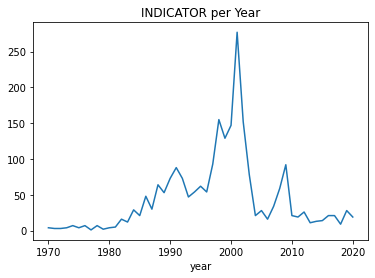

In [34]:
df2[df2['INDICATOR']==1].drop_duplicates(subset=['PERMNO'],keep='last').groupby('year')['INDICATOR'].sum().plot(title='INDICATOR per Year')

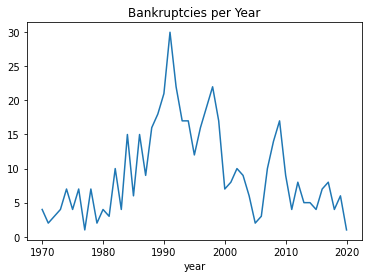

In [45]:
df2[((df2['combinedBankruptcyIndicator']==1))].drop_duplicates(subset=['PERMNO'],keep='last').groupby('year')['INDICATOR'].sum().plot(title='Bankruptcies per Year')

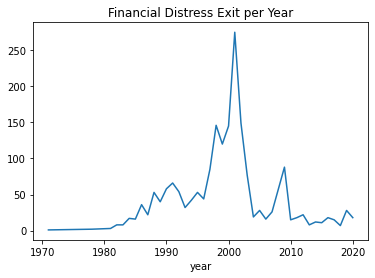

In [43]:
df2[((df2['financialExitWithin12Months']==1))].drop_duplicates(subset=['PERMNO'],keep='last').groupby('year')['INDICATOR'].sum().plot(title='Financial Distress Exit per Year')

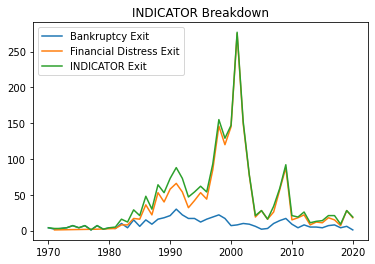

In [61]:
import matplotlib.pyplot as plt

bankruptcyExit = df2[((df2['combinedBankruptcyIndicator']==1))].drop_duplicates(subset=['PERMNO'],keep='last').groupby('year')['INDICATOR'].sum()
financialDistressExit = df2[((df2['financialExitWithin12Months']==1))].drop_duplicates(subset=['PERMNO'],keep='last').groupby('year')['INDICATOR'].sum()
indicatorExit = df2[df2['INDICATOR']==1].drop_duplicates(subset=['PERMNO'],keep='last').groupby('year')['INDICATOR'].sum()

'''
bankruptcyExit = bankruptcyExit.rename('count').reset_index()
bankruptcyExit['type'] = 'Bankruptcy Exit'

financialDistressExit = financialDistressExit.rename('count').reset_index()
financialDistressExit['type'] = 'Financial Distress Exit'

indicatorExit = indicatorExit.rename('count').reset_index()
indicatorExit['type'] = 'INDICATOR Exit'


totalStats = pd.concat([bankruptcyExit, financialDistressExit, indicatorExit], axis=0)
'''
bankruptcyExit = bankruptcyExit.rename('count').reset_index()
plt.plot(bankruptcyExit['year'], bankruptcyExit['count'], label='Bankruptcy Exit')

financialDistressExit = financialDistressExit.rename('count').reset_index()
plt.plot(financialDistressExit['year'], financialDistressExit['count'], label='Financial Distress Exit')

indicatorExit = indicatorExit.rename('count').reset_index()
plt.plot(indicatorExit['year'], indicatorExit['count'], label='INDICATOR Exit')
plt.title('INDICATOR Breakdown')
plt.legend()
plt.show()